In [1]:
from google.colab import files
uploaded = files.upload()

Saving xy_data.csv to xy_data.csv


✅ Optimal Parameters Found:
Theta (radians) = 0.4906842068
Theta (degrees) = 28.114134
M               = 0.0214153959
X               = 54.9009450758
Total L1 Error  = 37865.103083
Mean L1 per pt  = 25.243402


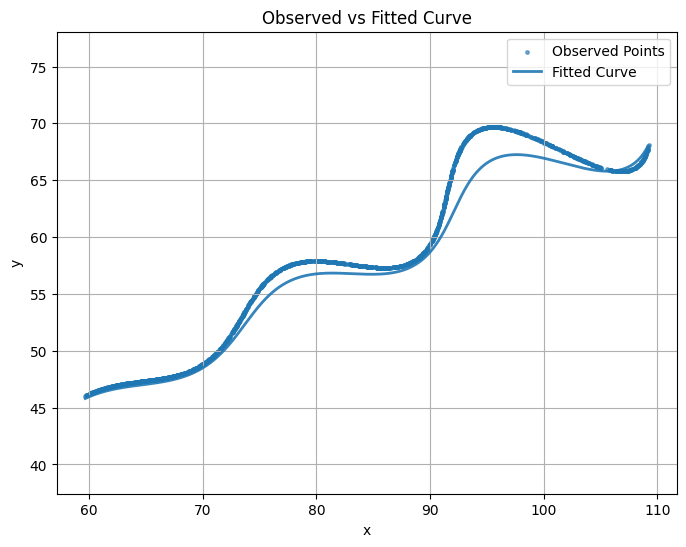

\left(t\cos(0.4906842068) - e^{0.0214153959|t|}\sin(0.3t)\sin(0.4906842068) + 54.9009450758,\; 42 + t\sin(0.4906842068) + e^{0.0214153959|t|}\sin(0.3t)\cos(0.4906842068)\right)


In [3]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- Load uploaded CSV ---
data = pd.read_csv('xy_data.csv')
x_obs = data['x'].values
y_obs = data['y'].values
n = len(data)

# --- Define parameter t ---
# (Assume uniformly sampled between 6 and 60)
t = np.linspace(6, 60, n)

# --- Define parametric model ---
def model(params, t):
    theta, M, X = params
    exp_term = np.exp(M * np.abs(t)) * np.sin(0.3 * t)
    x_pred = t * np.cos(theta) - exp_term * np.sin(theta) + X
    y_pred = 42 + t * np.sin(theta) + exp_term * np.cos(theta)
    return x_pred, y_pred

# --- Objective functions ---
def obj_L1(params):
    x_pred, y_pred = model(params, t)
    return np.sum(np.abs(x_pred - x_obs) + np.abs(y_pred - y_obs))

def obj_L2(params):
    x_pred, y_pred = model(params, t)
    return np.sum((x_pred - x_obs)**2 + (y_pred - y_obs)**2)

# --- Parameter bounds ---
bounds = [(1e-8, 50 * math.pi / 180 - 1e-8), (-0.05, 0.05), (1e-8, 100 - 1e-8)]
x0 = np.array([0.5, 0.0, 20.0])

# --- Stage 1: minimize L2 for smooth start ---
res_l2 = minimize(obj_L2, x0, method='L-BFGS-B', bounds=bounds)

# --- Stage 2: minimize L1 for final target metric ---
res_l1 = minimize(obj_L1, res_l2.x, method='Powell', bounds=bounds, options={'maxiter':20000})

theta_opt, M_opt, X_opt = res_l1.x
x_pred, y_pred = model(res_l1.x, t)

# --- Compute scores ---
total_L1 = np.sum(np.abs(x_pred - x_obs) + np.abs(y_pred - y_obs))
mean_L1 = total_L1 / n
theta_deg = theta_opt * 180 / math.pi

# --- Display results ---
print("✅ Optimal Parameters Found:")
print(f"Theta (radians) = {theta_opt:.10f}")
print(f"Theta (degrees) = {theta_deg:.6f}")
print(f"M               = {M_opt:.10f}")
print(f"X               = {X_opt:.10f}")
print(f"Total L1 Error  = {total_L1:.6f}")
print(f"Mean L1 per pt  = {mean_L1:.6f}")

# --- Plot observed vs fitted curve ---
plt.figure(figsize=(8,6))
plt.scatter(x_obs, y_obs, s=6, label='Observed Points', alpha=0.6)
plt.plot(x_pred, y_pred, '-', linewidth=2, label='Fitted Curve', alpha=0.9)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Observed vs Fitted Curve')
plt.grid(True)
plt.show()

# --- Generate LaTeX string for submission ---
latex_str = r"\left(t\cos({:.10f}) - e^{{{:.10f}|t|}}\sin(0.3t)\sin({:.10f}) + {:.10f},\; 42 + t\sin({:.10f}) + e^{{{:.10f}|t|}}\sin(0.3t)\cos({:.10f})\right)".format(
    theta_opt, M_opt, theta_opt, X_opt, theta_opt, M_opt, theta_opt
)

print(latex_str)
